In [129]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from causalgraphicalmodels import CausalGraphicalModel, StructuralCausalModel
import pylogit
from collections import OrderedDict
import pylogit as cm
from functools import reduce



import os
os.listdir('.')

['Causal_Graph_Tim_Data.ipynb',
 '_50_tb-cordon_toll_general_models--simplify_the_models.ipynb',
 'spring_2016_all_bay_area_long_format_plus_cross_bay_col.csv',
 '.ipynb_checkpoints']

In [7]:
data = pd.read_csv('spring_2016_all_bay_area_long_format_plus_cross_bay_col.csv')
data.columns

Index(['household_id', 'person_id', 'tour_id', 'observation_id', 'mode_id',
       'choice', 'tour_origin_taz', 'primary_dest_taz', 'total_travel_time',
       'total_travel_cost', 'total_travel_distance', 'age', 'household_size',
       'household_income', 'household_income_values', 'transit_subsidy',
       'transit_subsidy_amount', 'num_cars', 'num_licensed_drivers',
       'cross_bay', 'oakland_and_berkeley', 'survey_id', 'gender',
       'non_relative_flag', 'num_pre_school', 'num_school_aged', 'married',
       'parent', 'income_category_1', 'income_category_2', 'income_category_3',
       'income_category_4', 'income_category_5', 'income_category_6',
       'income_category_7', 'income_category_8', 'income_category_9',
       'income_category_10', 'income_unknown', 'ln_drive_cost',
       'ln_drive_cost_sq', 'total_travel_time_10x', 'total_travel_time_tenth',
       'high_income', 'medium_income', 'low_income', 'high_income_cost',
       'medium_income_cost', 'low_income_cost', 

In [17]:
data['mode_id'].unique()

array([1., 2., 3., 4., 5., 6., 7., 8.])

In [52]:
X_columns = ['total_travel_time',
       'total_travel_cost', 'total_travel_distance', 
             'cross_bay', 'household_size', 'num_kids', 
              'cars_per_licensed_drivers', 
             'gender'
             
            ]

y_column = data['mode_id']

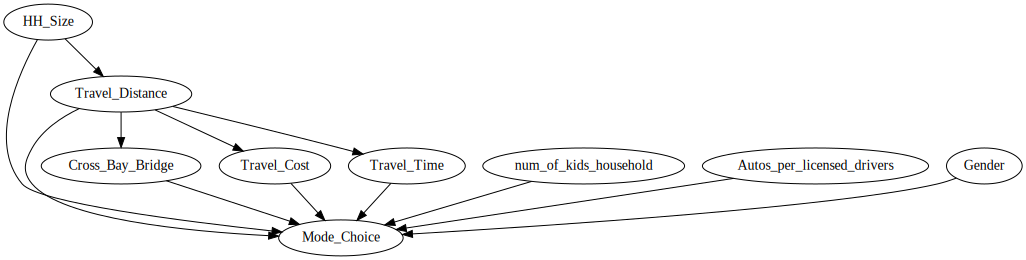

In [19]:
sprinkler = CausalGraphicalModel(
    nodes=["Travel_Time", "Travel_Distance", "Travel_Cost", "Cross_Bay_Bridge", "HH_Size", "num_of_kids_household",
          "Autos_per_licensed_drivers", "Gender", "Mode_Choice"],
    edges=[
        ("Travel_Time", "Mode_Choice"), 
        ("Travel_Distance", "Mode_Choice"), 
        ("Travel_Cost", "Mode_Choice"), 
        ("Cross_Bay_Bridge", "Mode_Choice"), 
        ("HH_Size", "Mode_Choice"), 
        ("num_of_kids_household", "Mode_Choice"), 
        ("Autos_per_licensed_drivers", "Mode_Choice"), 
        ("Gender", "Mode_Choice"), 
        
        
        ("Travel_Distance", "Travel_Time"), 
        ("Travel_Distance", "Travel_Cost"), 
        ("Travel_Distance", "Cross_Bay_Bridge"), 
        ("HH_Size", "Travel_Distance"), 

        
        
#         ("Travel_Time", "Mode_Choice"), 
#         ("Travel_Time", "Mode_Choice"), 

        
        
    ]
)

# draw return a graphviz `dot` object, which jupyter can render
sprinkler.draw()

# MNL specification

In [157]:
# Create my specification and variable names for the basic MNL model
# NOTE: - Keys should be variables within the long format dataframe.
#         The sole exception to this is the "intercept" key.
#       - For the specification dictionary, the values should be lists
#         or lists of lists. Within a list, or within the inner-most
#         list should be the alternative ID's of the alternative whose
#         utility specification the explanatory variable is entering.

mnl_specification = OrderedDict()
mnl_names = OrderedDict()

mnl_specification["intercept"] = list(range(2, 9))
mnl_names["intercept"] = ['ASC Shared Ride: 2',
                          'ASC Shared Ride: 3+',
                          'ASC Walk-Transit-Walk',
                          'ASC Drive-Transit-Walk',
                          'ASC Walk-Transit-Drive',
                          'ASC Walk',
                          'ASC Bike']

mnl_specification["total_travel_time"] = [1, 2, 3, [4, 5, 6]]
mnl_names["total_travel_time"] = ['Travel Time, units:min (Drive Alone)',
                                  'Travel Time, units:min (SharedRide-2)',
                                  'Travel Time, units:min (SharedRide-3)',
                                  'Travel Time, units:min (All Transit Modes)']

mnl_specification["total_travel_cost"] = [[4, 5, 6]]
mnl_names["total_travel_cost"] = ['Travel Cost, units:$ (All Transit Modes)']

mnl_specification["cost_per_distance"] = [1, 2, 3]
mnl_names["cost_per_distance"] = ["Travel Cost per Distance, units:$/mi (Drive Alone)",
                                  "Travel Cost per Distance, units:$/mi (SharedRide-2)",
                                  "Travel Cost per Distance, units:$/mi (SharedRide-3+)"]

mnl_specification["cars_per_licensed_drivers"] = [[1, 2, 3]]
mnl_names["cars_per_licensed_drivers"] = ["Autos per licensed drivers (All Auto Modes)"]

mnl_specification["total_travel_distance"] = [7, 8]
mnl_names["total_travel_distance"] = ['Travel Distance, units:mi (Walk)',
                                      'Travel Distance, units:mi (Bike)']

# mnl_specification["cross_bay"] = [[2, 3], [4, 5, 6]]
# mnl_names["cross_bay"] = ["Cross-Bay Tour (Shared Ride 2 & 3+)",
#                           "Cross-Bay Tour (All Transit Modes)"]
mnl_specification["cross_bay"] = [[2, 3]]
mnl_names["cross_bay"] = ["Cross-Bay Tour (Shared Ride 2 & 3+)"]

mnl_specification["household_size"] = [[2, 3]]
mnl_names["household_size"] = ['Household Size (Shared Ride 2 & 3+)']

mnl_specification["num_kids"] = [[2, 3]]
mnl_names["num_kids"] = ["Number of Kids in Household (Shared Ride 2 & 3+)"]

# Deconfounder

In [158]:
import tensorflow as tf
import numpy as np
import numpy.random as npr
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
import statsmodels.api as sm

from tensorflow_probability import edward2 as ed
from sklearn.datasets import load_breast_cancer
from pandas.plotting import scatter_matrix
from scipy import sparse, stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve

import matplotlib
matplotlib.rcParams.update({'font.sans-serif' : 'Helvetica',
                            'axes.labelsize': 10,
                            'xtick.labelsize' : 6,
                            'ytick.labelsize' : 6,
                            'axes.titlesize' : 10})
import matplotlib.pyplot as plt

import seaborn as sns
color_names = ["windows blue",
               "amber",
               "crimson",
               "faded green",
               "dusty purple",
               "greyish"]
colors = sns.xkcd_palette(color_names)
sns.set(style="white", palette=sns.xkcd_palette(color_names), color_codes = False)

In [159]:
X_columns = ['total_travel_time',
       'total_travel_cost', 
#              'total_travel_distance', 
             'cross_bay', 'household_size', 'num_kids', 
              'cars_per_licensed_drivers', 
             'gender'
             
            ]

y_column = data['mode_id']

In [160]:
spec_dic = specifications(mnl_specification=mnl_specification, num_modes=8)


TypeError: argument of type 'int' is not iterable

Analysis for mode:  1.0
-------------------------------------------------------------------------------------------
Inferred axes:
[[0.8891368  0.9509123  0.19287178]]
Standard Deviation:
[[0.00513591 0.00599076 0.00717137]]


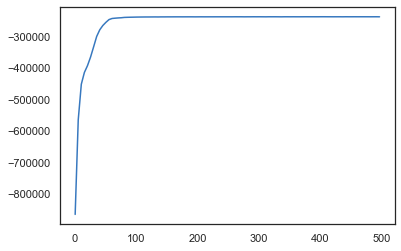

Analysis for mode:  2.0
-------------------------------------------------------------------------------------------
2.0 ['total_travel_time', 'cost_per_distance', 'cars_per_licensed_drivers', 'cross_bay', 'household_size', 'num_kids']
Inferred axes:
[[ 0.72384435  0.781833   -0.06371354  0.7776408  -0.6245476  -0.6168939 ]]
Standard Deviation:
[[0.00602762 0.00648229 0.00556669 0.00708958 0.00679492 0.00558957]]


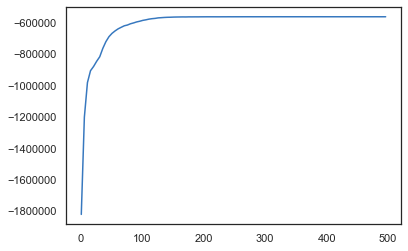

Analysis for mode:  3.0
-------------------------------------------------------------------------------------------
3.0 ['total_travel_time', 'cost_per_distance', 'cars_per_licensed_drivers', 'cross_bay', 'household_size', 'num_kids']
Inferred axes:
[[ 0.66495395  0.7299721  -0.09150483  0.7147484  -0.6664557  -0.6405521 ]]
Standard Deviation:
[[0.00692196 0.00558566 0.0058437  0.0063225  0.00624479 0.00578053]]


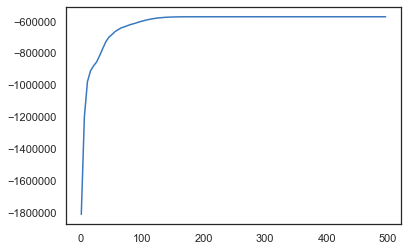

Analysis for mode:  4.0
-------------------------------------------------------------------------------------------
4.0 ['total_travel_time', 'total_travel_cost']
Inferred axes:
[[0.8604969 0.8684905]]
Standard Deviation:
[[0.00633423 0.00611814]]


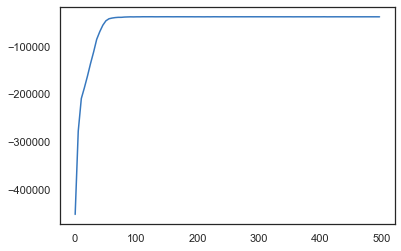

Analysis for mode:  5.0
-------------------------------------------------------------------------------------------
5.0 ['total_travel_time', 'total_travel_cost']
Inferred axes:
[[0.8672736  0.87810063]]
Standard Deviation:
[[0.00504779 0.00429956]]


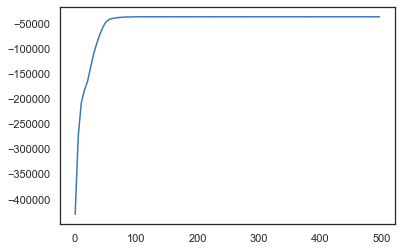

Analysis for mode:  6.0
-------------------------------------------------------------------------------------------
6.0 ['total_travel_time', 'total_travel_cost']
Inferred axes:
[[0.867982   0.89121294]]
Standard Deviation:
[[0.00507377 0.00622275]]


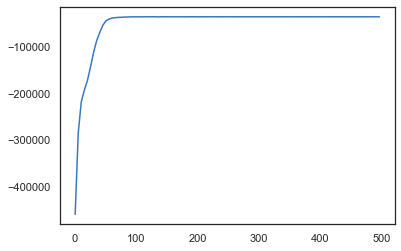

Analysis for mode:  7.0
-------------------------------------------------------------------------------------------
7.0 ['total_travel_distance']
Inferred axes:
[[1.0814904]]
Standard Deviation:
[[0.00742994]]


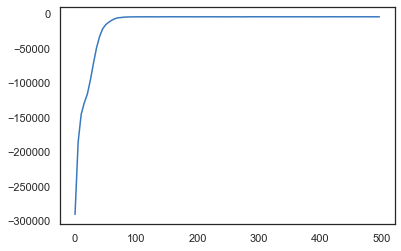

Analysis for mode:  8.0
-------------------------------------------------------------------------------------------
8.0 ['total_travel_distance']
Inferred axes:
[[1.0632582]]
Standard Deviation:
[[0.0072038]]


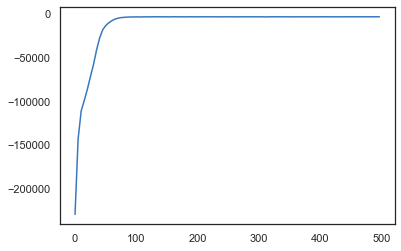

In [112]:
confounder_vectors = []
holdout_dfs = []
latent_dim = 1
for i in data['mode_id'].unique():

    data_mode_i = data[data['mode_id']==i]
    # standardize the data for PPCA
    print("Analysis for mode: ", i)
    print("-------------------------------------------------------------------------------------------")
    X_columns = spec_dic[i]
    
    if 'intercept' in X_columns:
        X_columns.remove('intercept')
        print(i, X_columns)
    
    X = np.array((data_mode_i[X_columns] - data_mode_i[X_columns].mean())/data_mode_i[X_columns].std())
    
    confounders, holdouts= confounder(holdout_portion=0.2, X=X, latent_dim=latent_dim)

    confounder_vectors.append(confounders)
    holdout_dfs.append(holdouts)

# Need to add predictive checks for confounder

## Adding confounders to original DF

In [161]:
for i in data['mode_id'].unique():
    
#     print(len(data.loc[data['mode_id']==i, col_name]), len(confounder_vectors[int(i-1)][2]) )
    
    col_name = 'confounder_for_mode_' + str(int(i))
    data.loc[data['mode_id']==i, col_name] = confounder_vectors[int(i-1)][2]
    data[col_name] = data[col_name].fillna(0)
    
data['confounder_all'] = data[['confounder_for_mode_1','confounder_for_mode_2','confounder_for_mode_3',
                              'confounder_for_mode_4', 'confounder_for_mode_5', 'confounder_for_mode_6',
                              'confounder_for_mode_7', 'confounder_for_mode_8']].sum(axis=1)

## Estimate non-causal MNL

In [162]:
# Estimate the basic MNL model, using the hessian and newton-conjugate gradient
mnl_model = cm.create_choice_model(data=data,
                                   alt_id_col="mode_id",
                                   obs_id_col="observation_id",
                                   choice_col="choice",
                                   specification=mnl_specification,
                                   model_type="MNL",
                                   names=mnl_names)

num_vars = len(reduce(lambda x, y: x + y, mnl_names.values()))
# Note newton-cg used to ensure convergence to a point where gradient 
# is essentially zero for all dimensions. 
mnl_model.fit_mle(np.zeros(num_vars),
                  method="BFGS")

# Look at the estimation results
mnl_model.get_statsmodels_summary()

Log-likelihood at zero: -7,599.7019
Initial Log-likelihood: -7,599.7019


/Users/hassanobeid/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))
/Users/hassanobeid/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:506: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.18 seconds.
Final log-likelihood: -4,961.8039


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Multinomial Logit Model Regression Results                    
===================================================================================
Dep. Variable:                      choice   No. Observations:                4,004
Model:             Multinomial Logit Model   Df Residuals:                    3,983
Method:                                MLE   Df Model:                           21
Date:                     Sat, 22 Feb 2020   Pseudo R-squ.:                   0.347
Time:                             18:02:01   Pseudo R-bar-squ.:               0.344
AIC:                             9,965.608   Log-Likelihood:             -4,961.804
BIC:                            10,097.804   LL-Null:                    -7,599.702
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
ASC Shared Ride: 2                                      -0.9437      0.502     -1.881      0.060      -1.927       0.039
ASC Shared Ride: 3+                                      1.3732      1.022      1.344      0.179      -0.630       3.376
ASC Walk-Transit-Walk                                   -0.4058      0.301     -1.347      0.178      -0.996       0.185
ASC Drive-Transit-Walk                                  -2.6927      0.315     -8.557      0.000      -3.309      -2.076
ASC Walk-Transit-Drive                                  -3.0483      0.318     -9.577      0.000      -3.672      -2.424
ASC Walk                                                 1.5791      0.320      4.938      0.000       0.952       2.206
ASC Bike                                                -1.1465      0.321     -3.577      0.000      -1.775      -0.518
Travel Time, units:min (Drive Alone)                    -0.0767      0.006    -13.481      0.000      -0.088      -0.066
Travel Time, units:min (SharedRide-2)                   -0.1019      0.006    -16.054      0.000      -0.114      -0.089
Travel Time, units:min (SharedRide-3)                   -0.1225      0.007    -17.763      0.000      -0.136      -0.109
Travel Time, units:min (All Transit Modes)              -0.0302      0.002    -13.469      0.000      -0.035      -0.026
Travel Cost, units:$ (All Transit Modes)                -0.1457      0.037     -3.900      0.000      -0.219      -0.072
Travel Cost per Distance, units:$/mi (Drive Alone)      -6.8393      1.473     -4.644      0.000      -9.726      -3.953
Travel Cost per Distance, units:$/mi (SharedRide-2)    -16.1904      4.683     -3.457      0.001     -25.370      -7.011
Travel Cost per Distance, units:$/mi (SharedRide-3+)   -50.4129     14.316     -3.521      0.000     -78.472     -22.354
Autos per licensed drivers (All Auto Modes)              1.2095      0.128      9.432      0.000       0.958       1.461
Travel Distance, units:mi (Walk)                        -1.0774      0.051    -21.084      0.000      -1.178      -0.977
Travel Distance, units:mi (Bike)                        -0.3167      0.025    -12.642      0.000      -0.366      -0.268
Cross-Bay Tour (Shared Ride 2 & 3+)                      1.4760      0.366      4.031      0.000       0.758       2.194
Household Size (Shared Ride 2 & 3+)                      0.1126      0.045      2.515      0.012       0.025       0.200
Number of Kids in Household (Shared Ride 2 & 3+)         0.5739      0.054     10.718      0.000       0.469       0.679
========================================================================================================================
"""

## Estimate Causal MNL

In [163]:
spec_dic

{1: ['total_travel_time', 'cost_per_distance', 'cars_per_licensed_drivers'],
 2: ['total_travel_time',
  'cost_per_distance',
  'cars_per_licensed_drivers',
  'cross_bay',
  'household_size',
  'num_kids'],
 3: ['total_travel_time',
  'cost_per_distance',
  'cars_per_licensed_drivers',
  'cross_bay',
  'household_size',
  'num_kids'],
 4: ['total_travel_time', 'total_travel_cost'],
 5: ['total_travel_time', 'total_travel_cost'],
 6: ['total_travel_time', 'total_travel_cost'],
 7: ['total_travel_distance'],
 8: ['total_travel_distance']}

In [166]:
mnl_specification_causal = mnl_specification.copy()
mnl_names_causal = mnl_names.copy()

mnl_specification_causal["confounder_all"] = [1, 2, 3]
mnl_names_causal["confounder_all"] = ["Confounder - Drive alone",
                                     "Confounder - Shared ride 2", 
                                     "Confounder - Shared ride 3"]

In [167]:
# Estimate the basic MNL model, using the hessian and newton-conjugate gradient
mnl_model_causal = cm.create_choice_model(data=data,
                                   alt_id_col="mode_id",
                                   obs_id_col="observation_id",
                                   choice_col="choice",
                                   specification=mnl_specification_causal,
                                   model_type="MNL",
                                   names=mnl_names_causal)

num_vars = len(reduce(lambda x, y: x + y, mnl_names_causal.values()))
# Note newton-cg used to ensure convergence to a point where gradient 
# is essentially zero for all dimensions. 
mnl_model_causal.fit_mle(np.zeros(num_vars),
                  method="BFGS")

# Look at the estimation results
mnl_model_causal.get_statsmodels_summary()

Log-likelihood at zero: -7,599.7019
Initial Log-likelihood: -7,599.7019
Estimation Time for Point Estimation: 0.20 seconds.
Final log-likelihood: -4,910.5336


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Multinomial Logit Model Regression Results                    
===================================================================================
Dep. Variable:                      choice   No. Observations:                4,004
Model:             Multinomial Logit Model   Df Residuals:                    3,980
Method:                                MLE   Df Model:                           24
Date:                     Sat, 22 Feb 2020   Pseudo R-squ.:                   0.354
Time:                             18:09:46   Pseudo R-bar-squ.:               0.351
AIC:                             9,869.067   Log-Likelihood:             -4,910.534
BIC:                            10,020.148   LL-Null:                    -7,599.702
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
ASC Shared Ride: 2                                       1.1554      0.639      1.808      0.071      -0.097       2.408
ASC Shared Ride: 3+                                     -1.4342      1.075     -1.334      0.182      -3.542       0.673
ASC Walk-Transit-Walk                                   -0.1859      0.414     -0.450      0.653      -0.996       0.625
ASC Drive-Transit-Walk                                  -2.4721      0.423     -5.837      0.000      -3.302      -1.642
ASC Walk-Transit-Drive                                  -2.8280      0.426     -6.642      0.000      -3.663      -1.994
ASC Walk                                                 1.7980      0.428      4.201      0.000       0.959       2.637
ASC Bike                                                -0.9309      0.428     -2.174      0.030      -1.770      -0.092
Travel Time, units:min (Drive Alone)                    -0.0752      0.006    -12.682      0.000      -0.087      -0.064
Travel Time, units:min (SharedRide-2)                   -0.1141      0.007    -16.992      0.000      -0.127      -0.101
Travel Time, units:min (SharedRide-3)                   -0.1115      0.007    -15.564      0.000      -0.126      -0.097
Travel Time, units:min (All Transit Modes)              -0.0301      0.002    -13.440      0.000      -0.034      -0.026
Travel Cost, units:$ (All Transit Modes)                -0.1477      0.037     -3.944      0.000      -0.221      -0.074
Travel Cost per Distance, units:$/mi (Drive Alone)      -6.0551      1.852     -3.270      0.001      -9.684      -2.426
Travel Cost per Distance, units:$/mi (SharedRide-2)    -30.6425      5.384     -5.691      0.000     -41.196     -20.089
Travel Cost per Distance, units:$/mi (SharedRide-3+)   -19.0474     14.299     -1.332      0.183     -47.073       8.978
Autos per licensed drivers (All Auto Modes)              1.2338      0.129      9.529      0.000       0.980       1.488
Travel Distance, units:mi (Walk)                        -1.0777      0.051    -21.055      0.000      -1.178      -0.977
Travel Distance, units:mi (Bike)                        -0.3164      0.025    -12.624      0.000      -0.366      -0.267
Cross-Bay Tour (Shared Ride 2 & 3+)                      1.1552      0.402      2.877      0.004       0.368       1.942
Household Size (Shared Ride 2 & 3+)                      0.1493      0.052      2.899      0.004       0.048       0.250
Number of Kids in Household (Shared Ride 2 & 3+)         0.6064      0.062      9.722      0.000       0.484       0.729
Confounder - Drive alone                                -0.0674      0.084     -0.801      0.423      -0.232       0.098
Confounder - Shared ride 2                               0.6686      0.153      4.382      0.000       0.370       0.968
Confounder - Shared ride 3                        

## Putting everything in a function

In [94]:
def confounder(X, latent_dim, holdout_portion):
    # randomly holdout some entries of X
    num_datapoints, data_dim = X.shape

    holdout_portion = holdout_portion
    n_holdout = int(holdout_portion * num_datapoints * data_dim)

    holdout_row = np.random.randint(num_datapoints, size=n_holdout)
    holdout_col = np.random.randint(data_dim, size=n_holdout)
    holdout_mask = (sparse.coo_matrix((np.ones(n_holdout), \
                                (holdout_row, holdout_col)), \
                                shape = X.shape)).toarray()

    holdout_subjects = np.unique(holdout_row)

    x_train = np.multiply(1-holdout_mask, X)
    x_vad = np.multiply(holdout_mask, X)

    def ppca_model(data_dim, latent_dim, num_datapoints, stddv_datapoints):
        w = ed.Normal(loc=tf.zeros([latent_dim, data_dim]),
                    scale=tf.ones([latent_dim, data_dim]),
                    name="w")  # parameter
        z = ed.Normal(loc=tf.zeros([num_datapoints, latent_dim]),
                    scale=tf.ones([num_datapoints, latent_dim]), 
                    name="z")  # local latent variable / substitute confounder
        x = ed.Normal(loc=tf.multiply(tf.matmul(z, w), 1-holdout_mask),
                    scale=stddv_datapoints * tf.ones([num_datapoints, data_dim]),
                    name="x")  # (modeled) data
        return x, (w, z)

    log_joint = ed.make_log_joint_fn(ppca_model)

    latent_dim = latent_dim
    stddv_datapoints = 0.1

    model = ppca_model(data_dim=data_dim,
                       latent_dim=latent_dim,
                       num_datapoints=num_datapoints,
                       stddv_datapoints=stddv_datapoints)

    def variational_model(qw_mean, qw_stddv, qz_mean, qz_stddv):
        qw = ed.Normal(loc=qw_mean, scale=qw_stddv, name="qw")
        qz = ed.Normal(loc=qz_mean, scale=qz_stddv, name="qz")
        return qw, qz


    log_q = ed.make_log_joint_fn(variational_model)

    def target(w, z):
        """Unnormalized target density as a function of the parameters."""
        return log_joint(data_dim=data_dim,
                       latent_dim=latent_dim,
                       num_datapoints=num_datapoints,
                       stddv_datapoints=stddv_datapoints,
                       w=w, z=z, x=x_train)

    def target_q(qw, qz):
        return log_q(qw_mean=qw_mean, qw_stddv=qw_stddv,
                   qz_mean=qz_mean, qz_stddv=qz_stddv,
                   qw=qw, qz=qz)


    qw_mean = tf.Variable(np.ones([latent_dim, data_dim]), dtype=tf.float32)
    qz_mean = tf.Variable(np.ones([num_datapoints, latent_dim]), dtype=tf.float32)
    qw_stddv = tf.nn.softplus(tf.Variable(-4 * np.ones([latent_dim, data_dim]), dtype=tf.float32))
    qz_stddv = tf.nn.softplus(tf.Variable(-4 * np.ones([num_datapoints, latent_dim]), dtype=tf.float32))

    qw, qz = variational_model(qw_mean=qw_mean, qw_stddv=qw_stddv,
                               qz_mean=qz_mean, qz_stddv=qz_stddv)


    energy = target(qw, qz)
    entropy = -target_q(qw, qz)

    elbo = energy + entropy


    optimizer = tf.train.AdamOptimizer(learning_rate = 0.05)
    train = optimizer.minimize(-elbo)

    init = tf.global_variables_initializer()

    t = []

    num_epochs = 500

    with tf.Session() as sess:
        sess.run(init)

        for i in range(num_epochs):
            sess.run(train)
            if i % 5 == 0:
                t.append(sess.run([elbo]))

            w_mean_inferred = sess.run(qw_mean)
            w_stddv_inferred = sess.run(qw_stddv)
            z_mean_inferred = sess.run(qz_mean)
            z_stddv_inferred = sess.run(qz_stddv)

    print("Inferred axes:")
    print(w_mean_inferred)
    print("Standard Deviation:")
    print(w_stddv_inferred)

    plt.plot(range(1, num_epochs, 5), t)
    plt.show()

    def replace_latents(w, z):

        def interceptor(rv_constructor, *rv_args, **rv_kwargs):
            """Replaces the priors with actual values to generate samples from."""
            name = rv_kwargs.pop("name")
            if name == "w":
                rv_kwargs["value"] = w
            elif name == "z":
                rv_kwargs["value"] = z
            return rv_constructor(*rv_args, **rv_kwargs)

        return interceptor
    
    return [w_mean_inferred, w_stddv_inferred, z_mean_inferred, z_stddv_inferred], x_vad

In [107]:

def specifications(mnl_specification, num_modes):
    newDict= dict()

    for i in range(1,num_modes+1):
        variables = []
        # Iterate over all the items in dictionary and filter items which has even keys
        for (key, value) in mnl_specification.items():
           # Check if key is even then add pair to new dictionary

            if any(isinstance(sub, list) for sub in value):
                if any(i in sl for sl in value):
                    variables.append(key)

            else:
                if i in value:
        #             print(variables)

                    variables.append(key)

        newDict[i] = variables

    return newDict